# Goal for Siraj Code Challenge

I want to build an classifier/autoencoder ensemble wich comes close to the best accuracy I know for MNIST Dataset without using CNNs: **0.9847**
Apart from a satisfiying accuracy I want a very efficient encoder which has the capability of reducing the dimensionality of the problem by at least 90%.

In [56]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.optimizers import RMSprop
from keras.callbacks import TensorBoard
from keras.utils import plot_model
from IPython.display import Image
from matplotlib import rc
from matplotlib import axes

import keras
import matplotlib.pyplot as plt
import numpy as np
import math
import pydot
import graphviz

font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 20}

rc('font', **font)

## Global Variables

In [3]:
num_classes = 10
input_dim = 784
encoder_dim = 32
epochsize = 50
batchsize = 256

## Data import and preprocessing

In [ ]:
(x_train, y_train), (x_val, y_val) = mnist.load_data()

(x_train, y_train), (x_val, y_val) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_val = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))

y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

## Neural Net Classifier with Single Autoencoder

In [ ]:
main_input = Input(shape=(input_dim,), dtype='float32', name='main_input')

encoding_layer = Dense(encoder_dim, activation='relu', kernel_initializer='normal')
encoding_layer_output = encoding_layer(main_input)
decoding_layer_output = Dense(input_dim
                              ,activation='sigmoid'
                              ,name='decoder_output'
                              ,kernel_initializer='normal')(encoding_layer_output)

classifier_output = Dense(num_classes
                          ,activation='softmax'
                          ,name='main_output'
                          ,kernel_initializer='normal')(encoding_layer_output)

auto_classifier = Model(inputs=main_input, outputs=[classifier_output, decoding_layer_output])

auto_classifier.compile(optimizer=RMSprop(),
                        loss={'main_output': 'categorical_crossentropy', 'decoder_output': 'mean_squared_error'},
                        loss_weights={'main_output':1., 'decoder_output': 1.},
                        metrics=['accuracy'])

In [15]:
plot_model(auto_classifier, to_file='images/mnist_dim_reduction.png', show_shapes=True, show_layer_names=True, rankdir='LR')

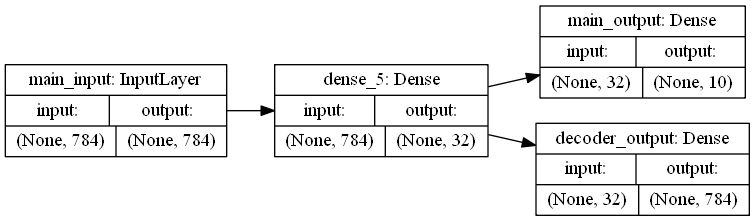

In [17]:
Image("images/mnist_dim_reduction.png")

In [ ]:
auto_classifier.fit({'main_input': x_train}
                    ,{'main_output': y_train, 'decoder_output': x_train}
                    ,epochs=epochsize
                    ,batch_size=batchsize
                    ,shuffle=True
                    ,validation_split=0.05
                    ,verbose=0
                    ,callbacks=[TensorBoard(log_dir='./logs')])

score = auto_classifier.evaluate(x=x_val, y=[y_val, x_val], verbose=1)[3]
print(score)

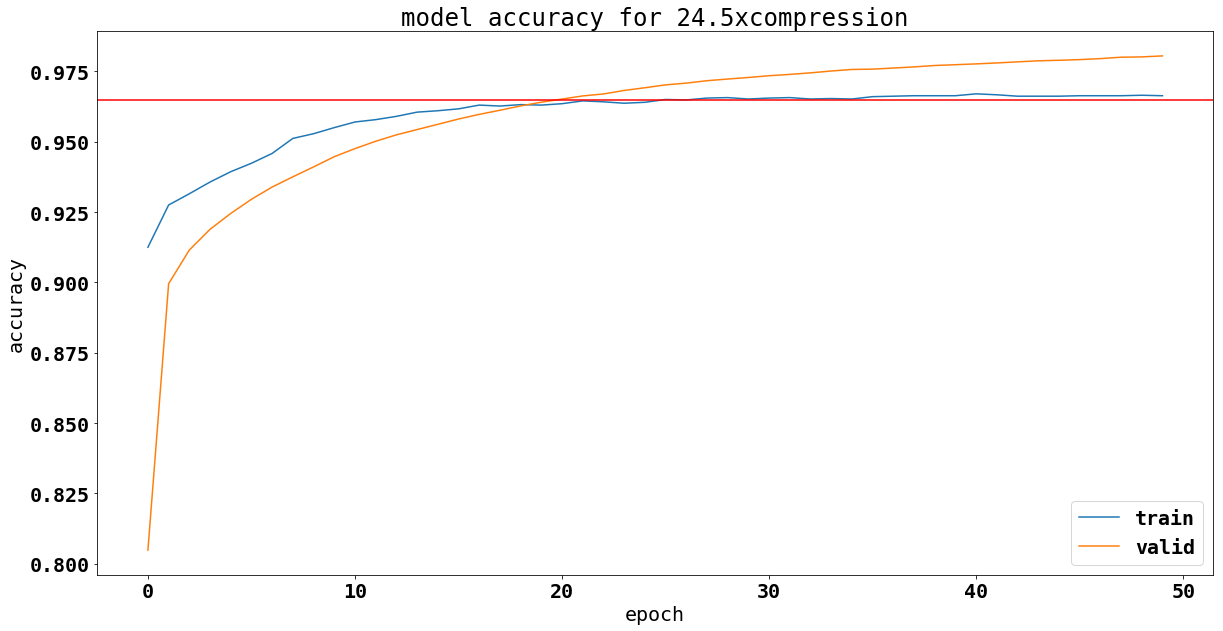

In [63]:
fig = plt.figure(figsize=(20,10))
plt.plot(auto_classifier.history.history['val_main_output_acc'])
plt.plot(auto_classifier.history.history['main_output_acc'])
plt.axhline(y=score[3], c="red")
plt.text(0, score, "test: " + str(round(score, 4)), fontdict=font)
plt.title('model accuracy for' + str(round(input_dim / encoder_dim, 2)) + ' x compression')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()